In [ ]:
!pip install pydicom torchvision tqdm scikit-image
from google.colab import drive
drive.mount('/content/drive')

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import pydicom
import cv2
import numpy as np
import torch
from glob import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.spatial.distance import directed_hausdorff
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_dicom_image(filepath):
    dicom = pydicom.dcmread(filepath)
    img = dicom.pixel_array
    img = img[:, :, 0] if len(img.shape) == 3 else img
    img_resized = cv2.resize(img, (256, 256))
    img_normalized = img_resized / img_resized.max()
    return img_normalized.astype(np.float32)

def load_dicom_mask(filepath):
    dicom = pydicom.dcmread(filepath)
    mask = dicom.pixel_array
    mask = mask[:, :, 0] if len(mask.shape) == 3 else mask
    mask_resized = cv2.resize(mask, (256, 256))
    mask_binary = (mask_resized > 50).astype(np.float32)
    return mask_binary


In [ ]:
class MRCTDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_dicom_image(self.image_paths[idx])
        mask = load_dicom_mask(self.mask_paths[idx])
        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return image, mask


In [ ]:
import os

def pad_dataset(image_paths, mask_paths, batch_size):
    n = len(image_paths)
    remainder = n % batch_size
    if remainder > 0:
        padding_size = batch_size - remainder
        image_paths.extend(image_paths[:padding_size])
        mask_paths.extend(mask_paths[:padding_size])
    return image_paths, mask_paths

batch_size = 4

root_dir = '/content/drive/MyDrive/z4wc364g79-1/JUH_MR-CT_dataset'
mr_image_paths = sorted(glob(os.path.join(root_dir, 'MR/image_MR/*.dcm')))
mr_mask_paths = sorted(glob(os.path.join(root_dir, 'MR/mask_MR/*.dcm')))
ct_image_paths = sorted(glob(os.path.join(root_dir, 'CT/image_CT/*.dcm')))
ct_mask_paths = sorted(glob(os.path.join(root_dir, 'CT/mask_CT/*.dcm')))

train_mr_image_paths, val_mr_image_paths, train_mr_mask_paths, val_mr_mask_paths = train_test_split(
    mr_image_paths, mr_mask_paths, test_size=0.2, random_state=42
)
train_ct_image_paths, val_ct_image_paths, train_ct_mask_paths, val_ct_mask_paths = train_test_split(
    ct_image_paths, ct_mask_paths, test_size=0.2, random_state=42
)

train_mr_image_paths, train_mr_mask_paths = pad_dataset(train_mr_image_paths, train_mr_mask_paths, batch_size)
train_ct_image_paths, train_ct_mask_paths = pad_dataset(train_ct_image_paths, train_ct_mask_paths, batch_size)
val_mr_image_paths, val_mr_mask_paths = pad_dataset(val_mr_image_paths, val_mr_mask_paths, batch_size)
val_ct_image_paths, val_ct_mask_paths = pad_dataset(val_ct_image_paths, val_ct_mask_paths, batch_size)

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_mr_dataset = MRCTDataset(train_mr_image_paths, train_mr_mask_paths, transform=data_transforms)
val_mr_dataset = MRCTDataset(val_mr_image_paths, val_mr_mask_paths, transform=data_transforms)
train_ct_dataset = MRCTDataset(train_ct_image_paths, train_ct_mask_paths, transform=data_transforms)
val_ct_dataset = MRCTDataset(val_ct_image_paths, val_ct_mask_paths, transform=data_transforms)

train_mr_dataloader = DataLoader(train_mr_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_mr_dataloader = DataLoader(val_mr_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
train_ct_dataloader = DataLoader(train_ct_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_ct_dataloader = DataLoader(val_ct_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

combined_train_dataset = torch.utils.data.ConcatDataset([train_mr_dataset, train_ct_dataset])
train_dataloader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


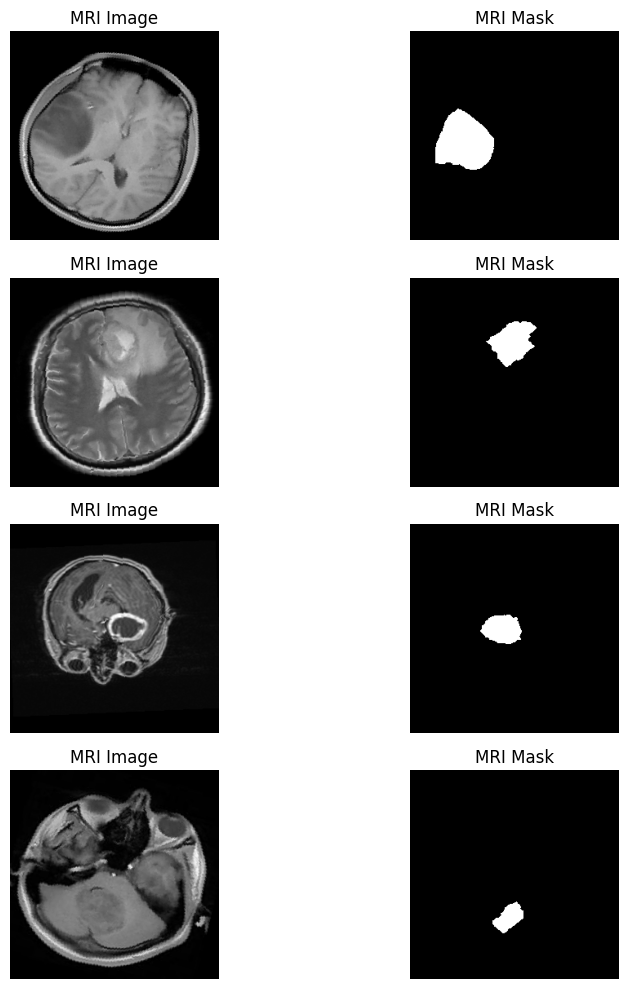

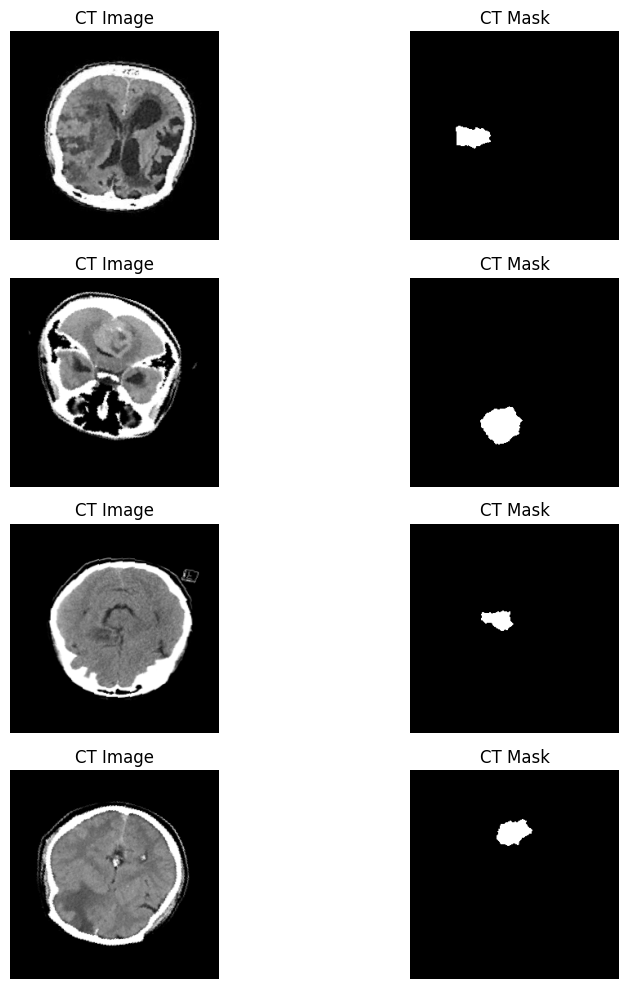

Shape of MRI images: torch.Size([4, 1, 256, 256])
Shape of MRI masks: torch.Size([4, 1, 256, 256])
Shape of CT images: torch.Size([4, 1, 256, 256])
Shape of CT masks: torch.Size([4, 1, 256, 256])


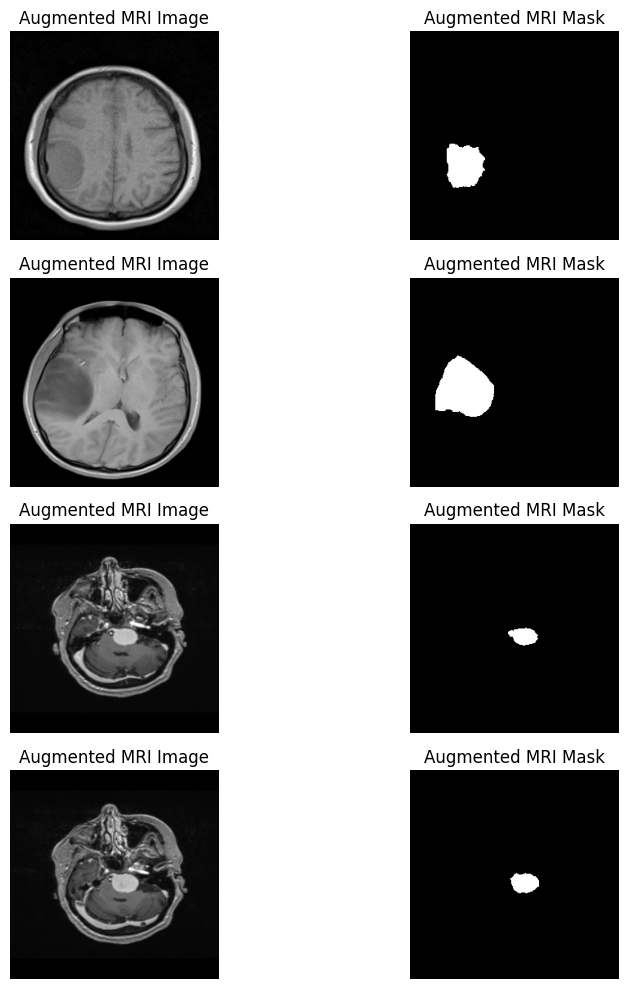

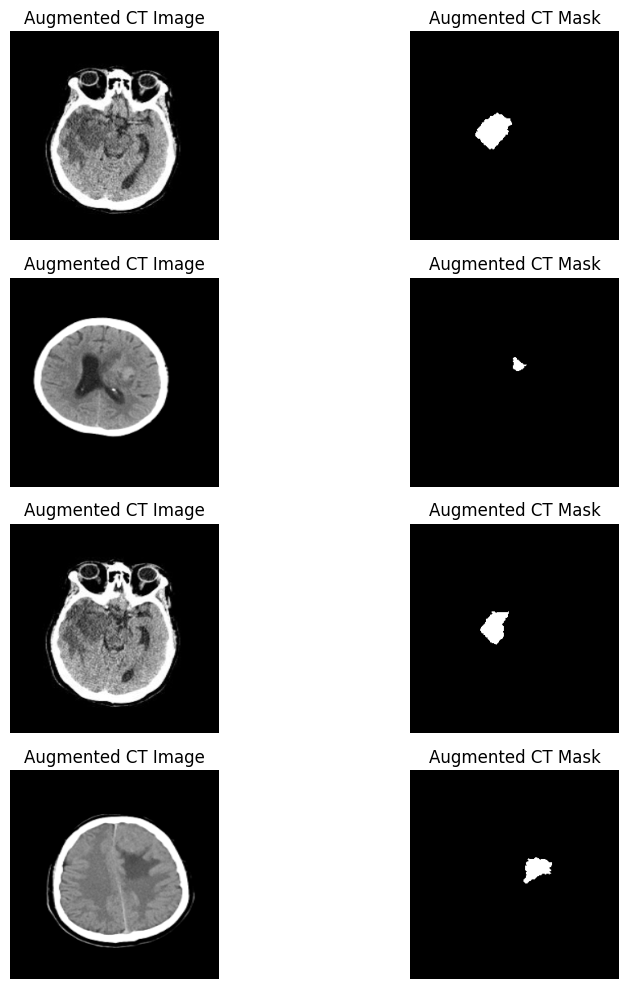

In [ ]:
def visualize_images(images, masks, titles):
    fig, axes = plt.subplots(len(images), 2, figsize=(10, 10))
    for i, (image, mask, title) in enumerate(zip(images, masks, titles)):
        axes[i, 0].imshow(image.squeeze(), cmap='gray')
        axes[i, 0].set_title(f'{title} Image')
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title(f'{title} Mask')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Get a single batch of images and masks from MRI dataloader
mri_images, mri_masks = next(iter(train_mr_dataloader))
visualize_images(mri_images.cpu().numpy(), mri_masks.cpu().numpy(), ['MRI' for _ in range(mri_images.shape[0])])

# Get a single batch of images and masks from CT dataloader
ct_images, ct_masks = next(iter(train_ct_dataloader))
visualize_images(ct_images.cpu().numpy(), ct_masks.cpu().numpy(), ['CT' for _ in range(ct_images.shape[0])])

# Verify shapes
print(f"Shape of MRI images: {mri_images.shape}")
print(f"Shape of MRI masks: {mri_masks.shape}")
print(f"Shape of CT images: {ct_images.shape}")
print(f"Shape of CT masks: {ct_masks.shape}")

# Visualize augmented images and masks
simple_transform = transforms.Compose([
    transforms.ToTensor()
])

train_mr_dataset_no_aug = MRCTDataset(train_mr_image_paths, train_mr_mask_paths, transform=simple_transform)
train_ct_dataset_no_aug = MRCTDataset(train_ct_image_paths, train_ct_mask_paths, transform=simple_transform)

train_mr_dataloader_no_aug = DataLoader(train_mr_dataset_no_aug, batch_size=batch_size, shuffle=True, num_workers=2)
train_ct_dataloader_no_aug = DataLoader(train_ct_dataset_no_aug, batch_size=batch_size, shuffle=True, num_workers=2)

aug_mri_images, aug_mri_masks = next(iter(train_mr_dataloader_no_aug))
visualize_images(aug_mri_images.cpu().numpy(), aug_mri_masks.cpu().numpy(), ['Augmented MRI' for _ in range(aug_mri_images.shape[0])])

aug_ct_images, aug_ct_masks = next(iter(train_ct_dataloader_no_aug))
visualize_images(aug_ct_images.cpu().numpy(), aug_ct_masks.cpu().numpy(), ['Augmented CT' for _ in range(aug_ct_images.shape[0])])


Ablation Study - I - CycleGAN Architecture

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [nn.Conv2d(64, output_nc, kernel_size=7, stride=1, padding=3)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        model += [nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# Initialize CycleGAN models
input_nc = 1
output_nc = 1
gen_mri_to_ct = Generator(input_nc, output_nc).to(device)
gen_ct_to_mri = Generator(input_nc, output_nc).to(device)
disc_mri = Discriminator(input_nc).to(device)
disc_ct = Discriminator(input_nc).to(device)


In [ ]:
import torch.optim as optim

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(
    list(gen_mri_to_ct.parameters()) + list(gen_ct_to_mri.parameters()),
    lr=0.0001,
    betas=(0.5, 0.999),
)
optimizer_D_mri = optim.Adam(disc_mri.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_ct = optim.Adam(disc_ct.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Learning rate schedulers
lr_scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: 1.0 - max(0, epoch + 1 - 100) / float(100 + 1))
lr_scheduler_D_mri = optim.lr_scheduler.LambdaLR(optimizer_D_mri, lr_lambda=lambda epoch: 1.0 - max(0, epoch + 1 - 100) / float(100 + 1))
lr_scheduler_D_ct = optim.lr_scheduler.LambdaLR(optimizer_D_ct, lr_lambda=lambda epoch: 1.0 - max(0, epoch + 1 - 100) / float(100 + 1))


Integrating ResNet50 Feature Extractor

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet50FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet50FeatureExtractor, self).__init__()
        resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(resnet50.children())[:7])
        self.features[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        return self.features(x)

# Initialize the feature extractor
feature_extractor = ResNet50FeatureExtractor().to(device)
feature_extractor.eval()  # Set to evaluation mode


ResNet50FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

Training Loop

In [ ]:
def feature_adaptation_loss(real_image, fake_image, feature_extractor):
    real_features = feature_extractor(real_image)
    fake_features = feature_extractor(fake_image)
    loss = nn.MSELoss()(real_features, fake_features)
    return loss


In [ ]:
def train_cycle_gan_with_feature_adaptation(num_epochs, dataloader, feature_extractor):
    for epoch in range(num_epochs):
        for i, (mri, ct) in enumerate(zip(train_mr_dataloader, train_ct_dataloader)):
            real_mri = mri[0].to(device).float()
            real_ct = ct[0].to(device).float()

            batch_size = real_mri.size(0)
            if batch_size != real_ct.size(0):
                print(f"Skipping batch with mismatched sizes: MRI batch size {batch_size}, CT batch size {real_ct.size(0)}")
                continue

            # Adversarial ground truths
            valid = torch.ones((batch_size, 1, 30, 30), requires_grad=False).to(device)
            fake = torch.zeros((batch_size, 1, 30, 30), requires_grad=False).to(device)

            # ------------------
            #  Train Generators
            # ------------------

            optimizer_G.zero_grad()

            # Identity loss
            loss_id_mri = criterion_identity(gen_ct_to_mri(real_mri), real_mri)
            loss_id_ct = criterion_identity(gen_mri_to_ct(real_ct), real_ct)

            loss_identity = (loss_id_mri + loss_id_ct) / 2

            # GAN loss
            fake_ct = gen_mri_to_ct(real_mri)
            loss_GAN_mri_to_ct = criterion_GAN(disc_ct(fake_ct), valid)
            fake_mri = gen_ct_to_mri(real_ct)
            loss_GAN_ct_to_mri = criterion_GAN(disc_mri(fake_mri), valid)

            loss_GAN = (loss_GAN_mri_to_ct + loss_GAN_ct_to_mri) / 2

            # Cycle loss
            recovered_mri = gen_ct_to_mri(fake_ct)
            loss_cycle_mri = criterion_cycle(recovered_mri, real_mri)
            recovered_ct = gen_mri_to_ct(fake_mri)
            loss_cycle_ct = criterion_cycle(recovered_ct, real_ct)

            loss_cycle = (loss_cycle_mri + loss_cycle_ct) / 2

            # Feature adaptation loss
            loss_feature_adapt_mri = feature_adaptation_loss(real_mri, fake_mri, feature_extractor)
            loss_feature_adapt_ct = feature_adaptation_loss(real_ct, fake_ct, feature_extractor)

            loss_feature_adaptation = (loss_feature_adapt_mri + loss_feature_adapt_ct) / 2

            # Total loss
            loss_G = loss_GAN + 5.0 * loss_cycle + 2.0 * loss_identity + 0.1 * loss_feature_adaptation
            loss_G.backward()
            optimizer_G.step()

            # -----------------------
            #  Train Discriminators
            # -----------------------

            # Discriminator MRI
            optimizer_D_mri.zero_grad()

            loss_real_mri = criterion_GAN(disc_mri(real_mri), valid)
            loss_fake_mri = criterion_GAN(disc_mri(fake_mri.detach()), fake)
            loss_D_mri = (loss_real_mri + loss_fake_mri) / 2

            loss_D_mri.backward()
            optimizer_D_mri.step()

            # Discriminator CT
            optimizer_D_ct.zero_grad()

            loss_real_ct = criterion_GAN(disc_ct(real_ct), valid)
            loss_fake_ct = criterion_GAN(disc_ct(fake_ct.detach()), fake)
            loss_D_ct = (loss_real_ct + loss_fake_ct) / 2

            loss_D_ct.backward()
            optimizer_D_ct.step()

            # Print log info
            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss G: {loss_G.item()}, Loss D_mri: {loss_D_mri.item()}, Loss D_ct: {loss_D_ct.item()}")

        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_mri.step()
        lr_scheduler_D_ct.step()

# Train CycleGAN with feature adaptation
train_cycle_gan_with_feature_adaptation(num_epochs=200, dataloader=train_dataloader, feature_extractor=feature_extractor)


Epoch [1/200], Step [1/36], Loss G: 0.9618330001831055, Loss D_mri: 0.20033641159534454, Loss D_ct: 0.12906013429164886
Epoch [1/200], Step [11/36], Loss G: 1.0734070539474487, Loss D_mri: 0.20080289244651794, Loss D_ct: 0.20280130207538605
Epoch [2/200], Step [1/36], Loss G: 0.923864483833313, Loss D_mri: 0.13607114553451538, Loss D_ct: 0.18568766117095947
Epoch [2/200], Step [11/36], Loss G: 1.1177376508712769, Loss D_mri: 0.09633538126945496, Loss D_ct: 0.3398725390434265
Epoch [3/200], Step [1/36], Loss G: 1.1870627403259277, Loss D_mri: 0.1995800882577896, Loss D_ct: 0.1636400818824768
Epoch [3/200], Step [11/36], Loss G: 0.8833364248275757, Loss D_mri: 0.24058794975280762, Loss D_ct: 0.20517992973327637
Epoch [4/200], Step [1/36], Loss G: 0.8386936783790588, Loss D_mri: 0.21759489178657532, Loss D_ct: 0.2581288814544678
Epoch [4/200], Step [11/36], Loss G: 0.8151128888130188, Loss D_mri: 0.22720740735530853, Loss D_ct: 0.24080020189285278
Epoch [5/200], Step [1/36], Loss G: 0.912

Evaluation - SSIM & PSNR Metrics

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Functions to compute SSIM and PSNR
def compute_ssim(img1, img2):
    img1 = img1.squeeze()
    img2 = img2.squeeze()
    return ssim(img1, img2, win_size=3)

def compute_psnr(img1, img2):
    img1 = img1.squeeze()
    img2 = img2.squeeze()
    return psnr(img1, img2)

# Evaluation function for CycleGAN
def evaluate_cycle_gan(epoch, num_epochs, val_mr_dataloader, val_ct_dataloader):
    gen_mri_to_ct.eval()
    gen_ct_to_mri.eval()

    total_ssim_ct = 0
    total_psnr_ct = 0
    total_ssim_mri = 0
    total_psnr_mri = 0
    total_ssim_recon_mri = 0
    total_psnr_recon_mri = 0
    total_ssim_recon_ct = 0
    total_psnr_recon_ct = 0
    num_samples = 0

    with torch.no_grad():
        for i, (mri, ct) in enumerate(zip(val_mr_dataloader, val_ct_dataloader)):
            real_mri = mri[0].to(device).float()
            real_ct = ct[0].to(device).float()

            fake_ct = gen_mri_to_ct(real_mri)
            recon_mri = gen_ct_to_mri(fake_ct)
            fake_mri = gen_ct_to_mri(real_ct)
            recon_ct = gen_mri_to_ct(fake_mri)

            ssim_ct = compute_ssim(real_ct.cpu().numpy(), fake_ct.cpu().numpy())
            psnr_ct = compute_psnr(real_ct.cpu().numpy(), fake_ct.cpu().numpy())
            ssim_mri = compute_ssim(real_mri.cpu().numpy(), fake_mri.cpu().numpy())
            psnr_mri = compute_psnr(real_mri.cpu().numpy(), fake_mri.cpu().numpy())
            ssim_recon_mri = compute_ssim(real_mri.cpu().numpy(), recon_mri.cpu().numpy())
            psnr_recon_mri = compute_psnr(real_mri.cpu().numpy(), recon_mri.cpu().numpy())
            ssim_recon_ct = compute_ssim(real_ct.cpu().numpy(), recon_ct.cpu().numpy())
            psnr_recon_ct = compute_psnr(real_ct.cpu().numpy(), recon_ct.cpu().numpy())

            total_ssim_ct += ssim_ct
            total_psnr_ct += psnr_ct
            total_ssim_mri += ssim_mri
            total_psnr_mri += psnr_mri
            total_ssim_recon_mri += ssim_recon_mri
            total_psnr_recon_mri += psnr_recon_mri
            total_ssim_recon_ct += ssim_recon_ct
            total_psnr_recon_ct += psnr_recon_ct
            num_samples += 1

    avg_ssim_ct = total_ssim_ct / num_samples
    avg_psnr_ct = total_psnr_ct / num_samples
    avg_ssim_mri = total_ssim_mri / num_samples
    avg_psnr_mri = total_psnr_mri / num_samples
    avg_ssim_recon_mri = total_ssim_recon_mri / num_samples
    avg_psnr_recon_mri = total_psnr_recon_mri / num_samples
    avg_ssim_recon_ct = total_ssim_recon_ct / num_samples
    avg_psnr_recon_ct = total_psnr_recon_ct / num_samples

    return avg_ssim_ct, avg_psnr_ct, avg_ssim_mri, avg_psnr_mri, avg_ssim_recon_mri, avg_psnr_recon_mri, avg_ssim_recon_ct, avg_psnr_recon_ct

# Summarize evaluation results
def summarize_evaluation_results(epoch, num_epochs, avg_ssim_ct, avg_psnr_ct, avg_ssim_mri, avg_psnr_mri, avg_ssim_recon_mri, avg_psnr_recon_mri, avg_ssim_recon_ct, avg_psnr_recon_ct):
    print("\n===== Evaluation Summary =====")
    print(f"Epoch: {epoch}/{num_epochs}")
    print(f"Average SSIM CT: {avg_ssim_ct:.4f}")
    print(f"Average PSNR CT: {avg_psnr_ct:.4f} dB")
    print(f"Average SSIM MRI: {avg_ssim_mri:.4f}")
    print(f"Average PSNR MRI: {avg_psnr_mri:.4f} dB")
    print(f"Average SSIM Reconstructed MRI: {avg_ssim_recon_mri:.4f}")
    print(f"Average PSNR Reconstructed MRI: {avg_psnr_recon_mri:.4f} dB")
    print(f"Average SSIM Reconstructed CT: {avg_ssim_recon_ct:.4f}")
    print(f"Average PSNR Reconstructed CT: {avg_psnr_recon_ct:.4f} dB")
    print("==============================\n")

# Evaluate the model after training
num_epochs = 200
avg_ssim_ct, avg_psnr_ct, avg_ssim_mri, avg_psnr_mri, avg_ssim_recon_mri, avg_psnr_recon_mri, avg_ssim_recon_ct, avg_psnr_recon_ct = evaluate_cycle_gan(
    epoch=num_epochs,
    num_epochs=num_epochs,
    val_mr_dataloader=val_mr_dataloader,
    val_ct_dataloader=val_ct_dataloader
)

# Summarize the evaluation results
summarize_evaluation_results(
    epoch=num_epochs,
    num_epochs=num_epochs,
    avg_ssim_ct=avg_ssim_ct,
    avg_psnr_ct=avg_psnr_ct,
    avg_ssim_mri=avg_ssim_mri,
    avg_psnr_mri=avg_psnr_mri,
    avg_ssim_recon_mri=avg_ssim_recon_mri,
    avg_psnr_recon_mri=avg_psnr_recon_mri,
    avg_ssim_recon_ct=avg_ssim_recon_ct,
    avg_psnr_recon_ct=avg_psnr_recon_ct
)



===== Evaluation Summary =====
Epoch: 200/200
Average SSIM CT: 0.5152
Average PSNR CT: 10.8009 dB
Average SSIM MRI: 0.2537
Average PSNR MRI: 12.4500 dB
Average SSIM Reconstructed MRI: 0.8626
Average PSNR Reconstructed MRI: 27.3526 dB
Average SSIM Reconstructed CT: 0.9245
Average PSNR Reconstructed CT: 27.6638 dB

